In [2]:
# Imports

# -- import local custom modules
import sys
sys.path.append('.')
import GlacierClass as gc
import plotutils as gpu

# -- import other modules
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import cartopy.crs as ccrs
from astropy.timeseries import LombScargle
import copy
import matplotlib.colors as colors
from scipy.stats import linregress
import seaborn as sns
import nisardev as nisar

# User-specified parameters

In [3]:
# Relative path for file geodatabase containing glacier information
fgdb = '../Greenland_Glaciers.gdb' # if file is shp rather than gdb, will need to update file read lines in the next cell
# -- File geodatabase layer names
termini_layer = 'glacier_termini'
points_layer = 'glacier_points'
boxes_layer = 'glacier_boxes'

# Other data files (for plotting and velocity analysis)
oceanmask_file = '../miscdata/GimpOceanMask_90m/GimpOceanMask_90m.shp' # Howat/MEaSUREs ocean mask, https://nsidc.org/data/nsidc-0714/versions/1 
basins_file = '../miscdata/GRE_Basins_IMBIE2_v1.3/GRE_Basins_IMBIE2_v1.3.shp' # Rignot Greenland drainage basins, http://imbie.org/imbie-3/drainage-basins/
velocity_file = '../miscdata/GL_vel_mosaic_Annual_01Dec19_30Nov20/GL_vel_mosaic_Annual_01Dec19_30Nov20_*_v03.0' # Joughin/MEaSUREs annual velocity for 2019-2020, https://nsidc.org/data/nsidc-0725/versions/4

# Relative path to save analysis output
outpath = '../analysis/'

# set figure style to The Cryosphere style parameters
gpu.globalDesignProperties('pub-cryo')
fw = gpu.figureWidth('pub-cryo')

# Prepare data for analysis

In [4]:
# LOAD AND CLEAN GLACIER DATA FILES

# -- Load glacier terminus data
termini = gpd.read_file(fgdb, layer=termini_layer, driver='FileGDB')
termini['Source_Date'] = pd.to_datetime(termini.Source_Date, errors='coerce')
termini['Glacier_ID'] = termini.Glacier_ID.astype('int')
termini['Quality_Flag'] = termini.Quality_Flag.astype('int')
# -- Reduce to Sentinel-1 termini only (will be 2015 onwards)
termini = termini[termini.Sensor == 'SEN1']
# -- Drop potential date duplicates
termini.drop_duplicates(subset=['Glacier_ID', 'Source_Date'], keep='first', inplace=True)

# -- Load glacier point locations
points = gpd.read_file(fgdb, layer=points_layer, driver='FileGDB')
points.sort_values(by='Glacier_ID', inplace=True)
points.set_index('Glacier_ID', drop=True, inplace=True)

# -- Load glacier reference boxes
refboxes = gpd.read_file(fgdb, layer=boxes_layer, driver='FileGDB')
refboxes.sort_values(by='Glacier_ID', inplace=True)
refboxes.set_index('Glacier_ID', drop=False, inplace=True)

In [5]:
# GET SCOPE OF GLACIERS AND TIME

# -- all glacier IDs in database
GIDS = termini.Glacier_ID.unique()
# -- exclude glaciers that were added for polar bear project
GIDS = GIDS[GIDS < 800] 
# -- remove glaciers with only a single entry (not valuable for seasonal analysis)
single_termini = []
for g in GIDS:
    i = len(termini[termini.Glacier_ID == g])
    if i == 1:
        single_termini.append(g)
single_termini
GIDS = list(set(GIDS) - set(single_termini))
# -- get list of glaciers digitized at six-day frequency
GIDS6 = [3, 7, 9, 13, 17, 19, 20, 21, 22, 23, 24, 32, 34, 35, 42, 46, 51, 65, 71, 81]
GIDS6_seasonal = [3, 7, 9, 13, 17, 19, 20, 21, 22, 23, 24, 32, 34, 35, 42, 46, 51, 71, 81]
# -- get list of glaciers digitized at monthly frequency
GIDSm = list(set(GIDS) - set(GIDS6))

# -- Get range of dates and years
DATE_START = termini.Source_Date.min()
DATE_END = termini.Source_Date.max()
YEAR_START = DATE_START.year
YEAR_END = DATE_END.year
YEARS = range(YEAR_START, YEAR_END+1)

In [6]:
# CONSTRUCT AN OBSERVATION TIME SERIES FOR EACH GLACIER

# -- Initialize dictionary of Glacier objects to store glacier information
all_glaciers = {id: gc.Glacier(id) for id in GIDS}
for id in all_glaciers:
    all_glaciers[id].refbox = refboxes.loc[id].geometry
    all_glaciers[id].officialname = points.loc[id].Official_Name
    all_glaciers[id].greenlandicname = points.loc[id].Greenlandic_Name
    all_glaciers[id].alternativename = points.loc[id].Alternative_Name

# -- Loop through glaciers to construct time series
for id in GIDS:

    # get reference line and all observations for GID
    glacier = termini.query('Glacier_ID == @id')
    
    # loop through all observations and process data
    for n in range(len(glacier)):
        observation = glacier.iloc[n]

        # create a Terminus Observation object for a row in geodataframe
        obs = gc.TerminusObservation(gid=int(observation.Glacier_ID),
                                     qflag=observation.Quality_Flag,
                                     termination='',
                                     imageid=observation.Image_ID,
                                     sensor=observation.Sensor,
                                     date=pd.to_datetime(observation.Source_Date),
                                     terminus=observation.geometry,
                                     referencebox=all_glaciers[id].refbox)
        
        # add glacier observation to time series
        all_glaciers[id].addObservation(obs)
    
    # update all attribute series for glacier
    all_glaciers[id].updateObservedValues()

# Manuscript data and figures

In [7]:
# BASIC DATASET STATS

# -- Get number of glaciers in each dataset
print(f'There are {len(GIDS)} glaciers in the entire dataset.')
print(f'There are {len(GIDSm)} glaciers in the monthly dataset.')
print(f'There are {len(GIDS6)} glaciers in the six-day dataset.')

# -- Get number of termini in each dataset
termini = termini[termini.Glacier_ID.isin(GIDS)]
monthly_termini = termini[termini.Glacier_ID.isin(GIDSm)]
sixday_termini = termini[termini.Glacier_ID.isin(GIDS6)]

print(f'\nThere are {len(termini)} termini in the entire dataset.')
print(f'There are {len(monthly_termini)} termini in the monthly dataset, or an average of {len(monthly_termini)/len(GIDSm):.0f} per glacier.')
print(f'There are {len(sixday_termini)} termini in the six-day dataset, or an average of {len(sixday_termini)/len(GIDS6):.0f} per glacier.')

# -- Get number of images used for each dataset
print(f'\nWe used {len(termini.Image_ID.unique())} SAR mosaics for the entire dataset. This includes different versions of the same date range.')
print(f'Combining versions, we used {len(termini.Image_ID.str[-17:].unique())} mosaic date ranges for the entire dataset.')


There are 219 glaciers in the entire dataset.
There are 199 glaciers in the monthly dataset.
There are 20 glaciers in the six-day dataset.

There are 23333 termini in the entire dataset.
There are 16282 termini in the monthly dataset, or an average of 82 per glacier.
There are 7051 termini in the six-day dataset, or an average of 353 per glacier.

We used 404 SAR mosaics for the entire dataset. This includes different versions of the same date range.
Combining versions, we used 373 mosaic date ranges for the entire dataset.


## Figure 1: Map of study area

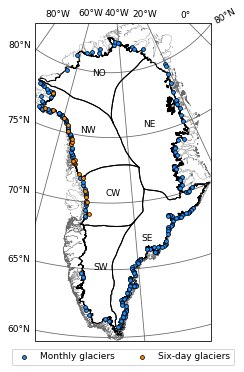

In [8]:
# MAP OF STUDY AREA

# -- Load datasets
coastline = gpd.read_file(oceanmask_file)
coastline.to_crs(points.crs, inplace=True)
basins = gpd.read_file(basins_file)
basins.to_crs(points.crs, inplace=True)
basins = basins[basins.SUBREGION1 != 'ICE_CAP']

# -- Plot Greenland outline, drainage basins (labeled), and glacier locations
fig, ax = plt.subplots(figsize=(fw, fw*2), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)})
coastline.plot(ax=ax, linewidth=0.25, color='dimgray')
basins.plot(ax=ax, edgecolor='black', facecolor='none')
basins.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
points[points.index.isin(GIDSm)].plot(ax=ax, markersize=15, color='dodgerblue', edgecolor='black', linewidth=0.75, zorder=2, label='Monthly glaciers')
points[points.index.isin(GIDS6)].plot(ax=ax, markersize=15, color='darkorange', edgecolor='black', linewidth=0.75, zorder=2, label='Six-day glaciers')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2)

# -- Narrow plot bounds slightly
xmin, ymin, xmax, ymax = coastline.total_bounds
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# -- Set gridline properties to display as lat/lon and below other features
gl = ax.gridlines(
    transform=ccrs.Geodetic(), 
    draw_labels=True,
    x_inline=False,
    y_inline=False,
    color='dimgray',
    zorder=0.5)
gl.top_labels = True
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'rotation': 0}
gl.ylabel_style = {'rotation': 0}

plt.savefig('../figures/fig1_map.png', dpi=300, bbox_inches='tight')

In [9]:
# GROUP GLACIER IDS INTO EACH REGION
GIDS_CW = [x for x in (list(range(1,18))) if x in GIDS]
GIDS_NW = [x for x in (list(range(18,91))) if x in GIDS]
GIDS_NO = [x for x in (list(range(91,106)) + [210]) if x in GIDS]
GIDS_NE = [x for x in (list(range(106,125)) + [211, 212, 213, 214, 237, 239]) if x in GIDS]
GIDS_SE = [x for x in (list(range(125,203)) + list(range(215, 236)) + [238, 801, 802, 803, 804]) if x in GIDS]
GIDS_SW = [x for x in (list(range(203,210)) + [236]) if x in GIDS]

## Tables S1 and S2: Names and locations of monthly and six-day glaciers

In [10]:
# Create a table of glacier IDs, names, and terminus centroids for monthly glaciers
def get_centroid(gid, epsg):
    """Find single point (centroid) that represents all termini for a glacier.Returns lat and lon."""
    all_centroids = gpd.GeoDataFrame(geometry=termini[termini.Glacier_ID == gid].geometry.centroid)
    one_centroid = all_centroids.dissolve().centroid.to_crs(f'epsg:{epsg}')
    latlon = f'({one_centroid.y[0]:.3f}, {one_centroid.x[0]:.3f})'
    return one_centroid.y, one_centroid.x, latlon

tableS1 = pd.DataFrame(index=GIDSm, columns=['Name', 'Coordinates'])
tableS1['Name'] = [all_glaciers[g].getGlacierName() for g in tableS1.index.values]
tableS1['Coordinates'] = [get_centroid(g, epsg=4326)[2] for g in tableS1.index.values]
tableS1

,Name,Coordinates
1,Saqqarliup Sermia (Sarqardliup Sermia),"(68.899, -50.319)"
2,Alanngorliup Sermia (Alangordliup Sermia),"(68.953, -50.221)"
4,Sermeq Avannarleq (Sermeq Avannarleq A),"(69.361, -50.315)"
5,Eqip Sermia ( ),"(69.793, -50.226)"
6,Kangilernata Sermia (Kangilerngata Sermia),"(69.903, -50.341)"
...,...,...
235,Glacier #235,"(60.841, -43.589)"
236,Qooqqup Sermia ( ),"(61.195, -45.201)"
237,Stormgletsjer,"(75.657, -22.222)"
238,Glacier #238,"(60.725, -43.801)"


In [11]:
# Create a table of glacier IDs, names, and terminus centroids for six-day glaciers
tableS2 = pd.DataFrame(index=GIDS6, columns=['Name', 'Coordinates'])
tableS2['Name'] = [all_glaciers[g].getGlacierName() for g in tableS2.index.values]
tableS2['Coordinates'] = [get_centroid(g, epsg=4326)[2] for g in tableS2.index.values]
tableS2

,Name,Coordinates
3,Sermeq Kujalleq (Jakobshavn Isbræ),"(69.194, -49.651)"
7,Sermeq Kujalleq (Alianaatsup Sermia),"(69.999, -50.228)"
9,Sermeq Kujalleq (Store Gletsjer),"(70.383, -50.601)"
13,Sermeq Silarleq (Sermeq Silardleq),"(70.827, -50.757)"
17,Kangilliup Sermia (Rink Isbræ),"(71.736, -51.661)"
19,Salliarutsip Sermia (Inngia Isbræ),"(72.065, -52.545)"
20,Glacier #20,"(72.787, -54.233)"
21,Sermeq (Upernavik Isstrøm),"(72.848, -54.349)"
22,Glacier #22,"(72.937, -54.282)"
23,Glacier #23,"(73.024, -54.443)"


## Define functions for analysis

In [12]:
def detrend(data):
    """Detrend data based on first and last values (Ben Smith suggestion)."""
    y_0, y_1 = data[0], data[-1]
    trend = pd.Series(index=data.index, dtype='float64')
    trend.iloc[0] = y_0
    trend.iloc[-1] = y_1
    trend = trend.interpolate(method='linear')
    data_detrended = data - trend
    return data_detrended

## Figure 2: Monthly glacier lengths for all glaciers (heatmap)

<ipython-input-13-5093ea3b6851>:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(gml, extend='both', label='Relative length (km)')


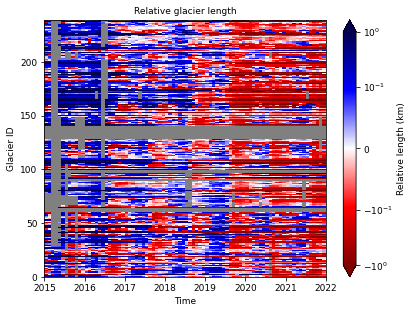

In [13]:
# create dataframe of monthly relative lengths for each glacier
annual_months = pd.date_range(start='2015-01-01', end='2021-12-01', freq='MS').to_period('M')
gml_gids = range(1,240)
glaciers_monthly_lengths = pd.DataFrame(index=gml_gids, columns=annual_months)

# compute length per month for all glaciers (mostly just filtering down the six-day glaciers)
for id in GIDS:
    glacier = all_glaciers[id]
    if not glacier.lengths.empty:
        lengths = pd.Series(glacier.lengths.values, index=glacier.dates.dt.to_period('M'))
        monthly_lengths = lengths[~lengths.index.duplicated(keep='first')]
        rel_monthly_lengths = monthly_lengths - monthly_lengths.mean()
        glaciers_monthly_lengths.loc[id] = rel_monthly_lengths

# set colormap properties
cmap = copy.copy(plt.cm.get_cmap('seismic_r'))
cmap.set_bad(color='gray') # plot missing data as gray

# plot "heatmap" of relative glacier lengths over time for monthly data
fig, ax = plt.subplots(figsize=(fw*2, fw*1.5))
ax.grid(False)
gml = ax.pcolormesh(
    glaciers_monthly_lengths.values.astype('float'), 
    cmap=cmap, 
    norm=colors.SymLogNorm(linthresh=0.1, vmin=-1, vmax=1))
ax.set_xticks(range(0,len(annual_months)+1,12))
ax.set_xticklabels(['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])
ax.set_xlabel('Time')
ax.set_ylabel('Glacier ID')
ax.set_title('Relative glacier length')
plt.colorbar(gml, extend='both', label='Relative length (km)')

plt.savefig('../figures/fig2_lengths_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Supplementary figures 2,3: length plots for individual glaciers

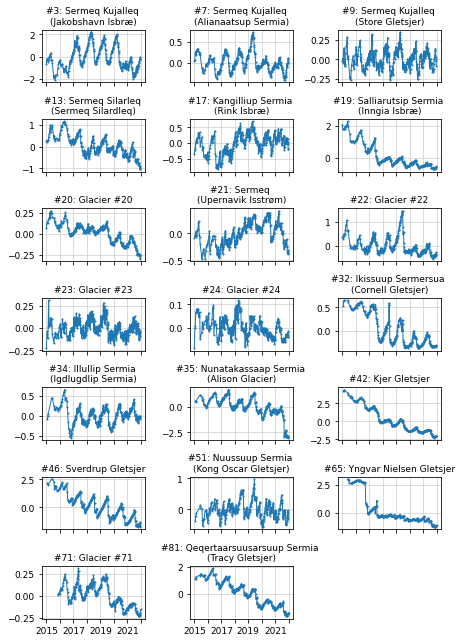

In [14]:
# Plot lengths for the 20 six-day glaciers in one plot

fig, ax = plt.subplots(nrows=7, ncols=3, sharex=True, figsize=(fw*2,9))
ax = ax.flatten()

for id in GIDS6:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()
    # qflags = pd.Series(glacier.extract('qflag').values, index=glacier.dates)

    n = GIDS6.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    # ax[n].scatter(lengths[qflags==0].index, lengths[qflags==0].values, marker='.', label='Certain position')
    # ax[n].scatter(lengths[qflags!=0].index, lengths[qflags!=0].values, marker='.', color='red', zorder=3)
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-1].axis('off')
ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/figS2_sixday_lengths.png', dpi=300, bbox_inches='tight')

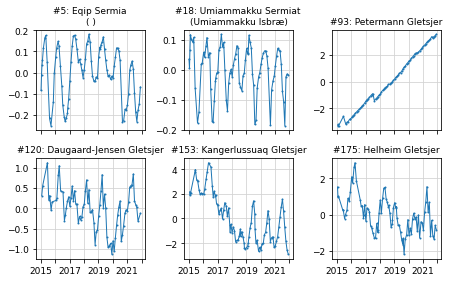

In [15]:
# Plot lengths for select monthly glaciers in one plot
# 5 - Eqip Sermia
# 18 - Umiammakku Sermiat
# 93 - Petermann
# 120 - Daugaard-Jensen
# 153 - Kangerlussuaq
# 175 - Helheim
figs2_ids = [5, 18, 93, 120, 153, 175]

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(fw*2,4))
ax = ax.flatten()

for id in figs2_ids:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()
    # qflags = pd.Series(glacier.extract('qflag').values, index=glacier.dates)

    n = figs2_ids.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    # ax[n].scatter(lengths[qflags==0].index, lengths[qflags==0].values, marker='.', label='Certain position')
    # ax[n].scatter(lengths[qflags!=0].index, lengths[qflags!=0].values, marker='.', color='red', zorder=3)
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/figS3_select_monthly_lengths.png', dpi=300, bbox_inches='tight')

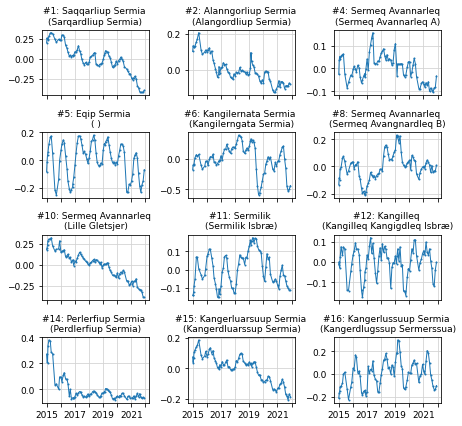

In [16]:
# Plot lengths for the 12 monthly CW GrIS glaciers in one plot
cw_m = [x for x in GIDS_CW if x not in GIDS6]

fig, ax = plt.subplots(nrows=4, ncols=3, sharex=True, figsize=(fw*2,6))
ax = ax.flatten()

for id in cw_m:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = cw_m.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_CW.png', dpi=300, bbox_inches='tight')

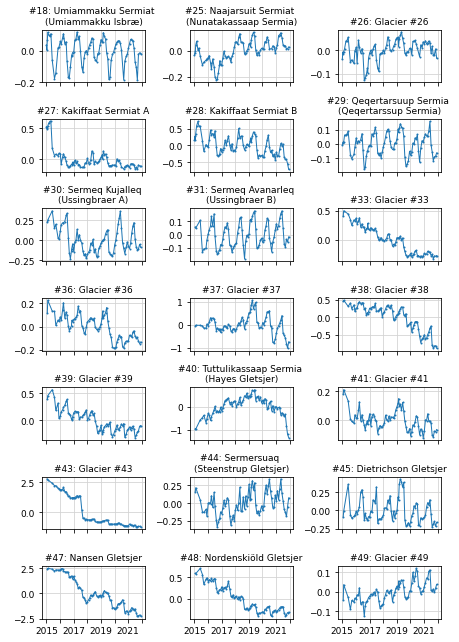

In [17]:
# Plot lengths for the 53 monthly NW GrIS glaciers in three plots
nw_m = [x for x in GIDS_NW if x not in GIDS6]
nw_ma = nw_m[0:21]
nw_mb = nw_m[21:42]
nw_mc = nw_m[42:]

fig, ax = plt.subplots(nrows=7, ncols=3, sharex=True, figsize=(fw*2,9))
ax = ax.flatten()

for id in nw_ma:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = nw_ma.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_NW-A.png', dpi=300, bbox_inches='tight')

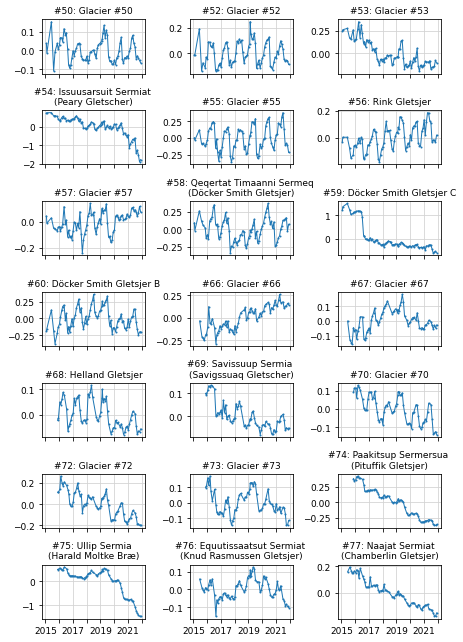

In [18]:
# NW monthly glaciers plot B

fig, ax = plt.subplots(nrows=7, ncols=3, sharex=True, figsize=(fw*2,9))
ax = ax.flatten()

for id in nw_mb:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = nw_mb.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_NW-B.png', dpi=300, bbox_inches='tight')

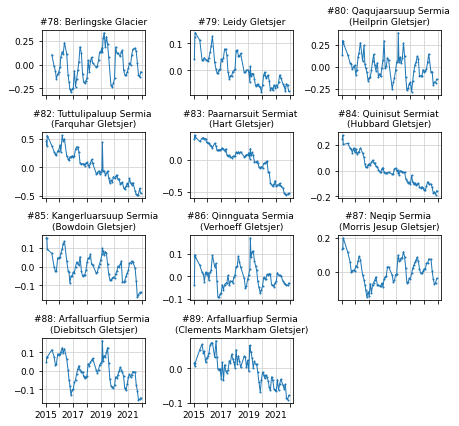

In [19]:
# NW monthly glaciers plot C

fig, ax = plt.subplots(nrows=4, ncols=3, sharex=True, figsize=(fw*2,6))
ax = ax.flatten()

for id in nw_mc:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = nw_mc.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
ax[-1].axis('off')
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_NW-C.png', dpi=300, bbox_inches='tight')

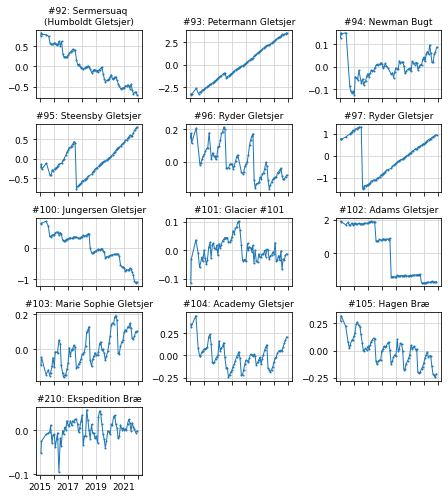

In [20]:
# Plot lengths for the 13 monthly NO GrIS glaciers
no_m = [x for x in GIDS_NO if x not in GIDS6]

fig, ax = plt.subplots(nrows=5, ncols=3, sharex=True, figsize=(fw*2,7))
ax = ax.flatten()

for id in no_m:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = no_m.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
ax[-1].axis('off')
ax[-2].axis('off')
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_NO.png', dpi=300, bbox_inches='tight')

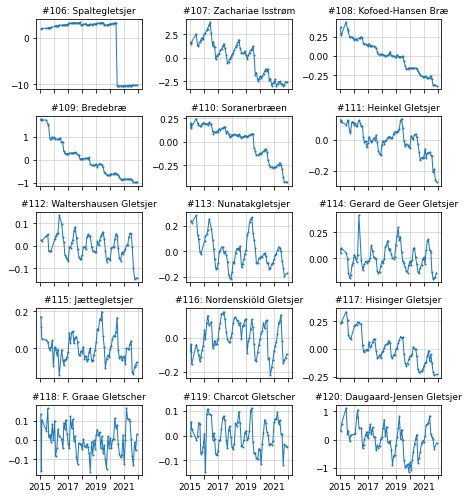

In [21]:
# Plot lengths for the 25 monthly NE GrIS glaciers in two plots
ne_m = [x for x in GIDS_NE if x not in GIDS6]
ne_ma = ne_m[0:15]
ne_mb = ne_m[15:]

fig, ax = plt.subplots(nrows=5, ncols=3, sharex=True, figsize=(fw*2,7))
ax = ax.flatten()

for id in ne_ma:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = ne_ma.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_NE-A.png', dpi=300, bbox_inches='tight')

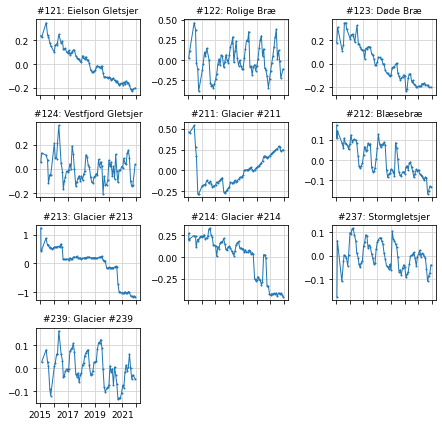

In [22]:
# NE glacier lengths - B

fig, ax = plt.subplots(nrows=4, ncols=3, sharex=True, figsize=(fw*2,6))
ax = ax.flatten()

for id in ne_mb:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = ne_mb.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
ax[-1].axis('off')
ax[-2].axis('off')
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_NE-B.png', dpi=300, bbox_inches='tight')

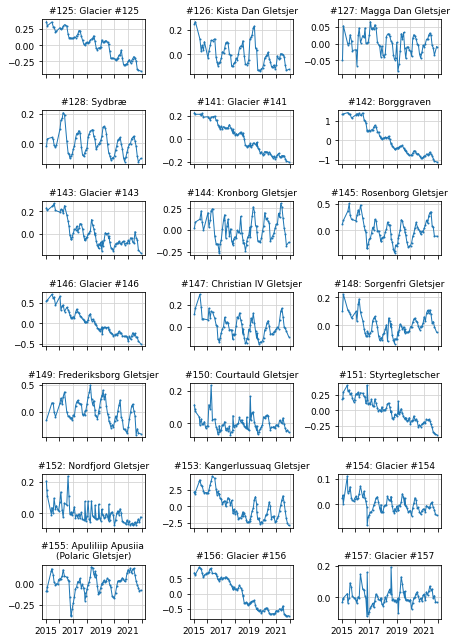

In [23]:
# Plot lengths for the 88 monthly SE GrIS glaciers in two plots
se_m = [x for x in GIDS_SE if x not in GIDS6]
se_ma = se_m[0:21]
se_mb = se_m[21:42]
se_mc = se_m[42:63]
se_md = se_m[63:84]
se_me = se_m[84:]

fig, ax = plt.subplots(nrows=7, ncols=3, sharex=True, figsize=(fw*2,9))
ax = ax.flatten()

for id in se_ma:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = se_ma.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_SE-A.png', dpi=300, bbox_inches='tight')

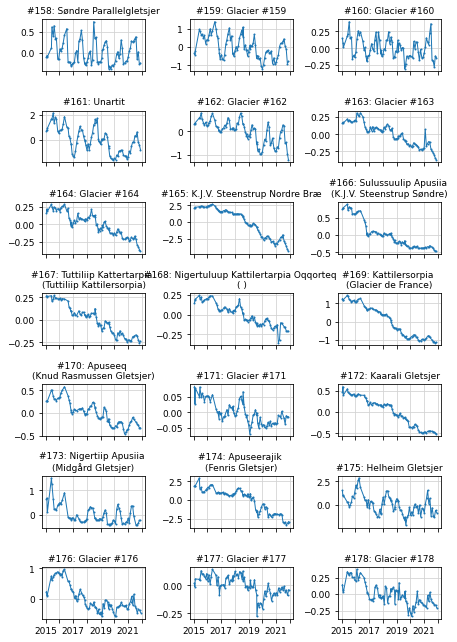

In [24]:
# SE glacier lengths - B

fig, ax = plt.subplots(nrows=7, ncols=3, sharex=True, figsize=(fw*2,9))
ax = ax.flatten()

for id in se_mb:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = se_mb.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_SE-B.png', dpi=300, bbox_inches='tight')

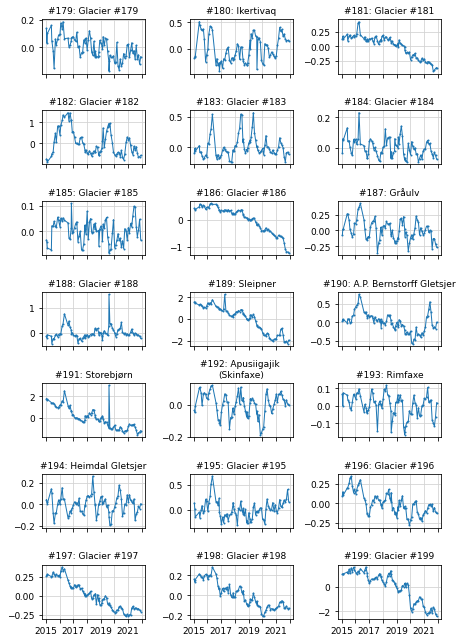

In [25]:
# SE glacier lengths - C

fig, ax = plt.subplots(nrows=7, ncols=3, sharex=True, figsize=(fw*2,9))
ax = ax.flatten()

for id in se_mc:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = se_mc.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_SE-C.png', dpi=300, bbox_inches='tight')

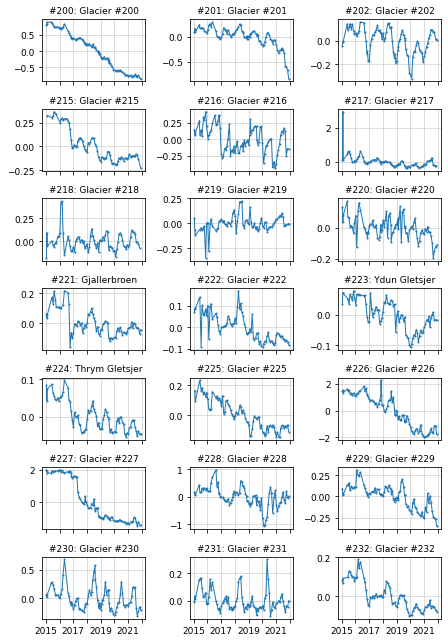

In [26]:
# SE glacier lengths - D

fig, ax = plt.subplots(nrows=7, ncols=3, sharex=True, figsize=(fw*2,9))
ax = ax.flatten()

for id in se_md:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = se_md.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_SE-D.png', dpi=300, bbox_inches='tight')

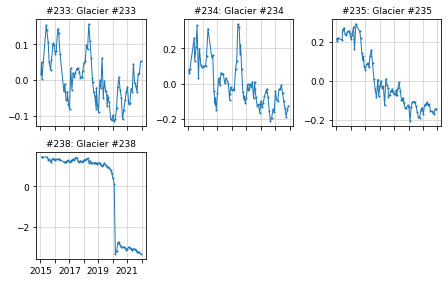

In [27]:
# SE glacier lengths - E

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(fw*2,4))
ax = ax.flatten()

for id in se_me:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths = lengths - lengths.mean()

    n = se_me.index(id)
    ax[n].plot(lengths.index, lengths.values, '.-')
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')

ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
ax[-1].axis('off')
ax[-2].axis('off')
plt.tight_layout()

plt.savefig('../figures/monthly_lengths_SE-E.png', dpi=300, bbox_inches='tight')

## Analysis: determine seasonal cycle significance for every glacier

In [28]:
# LOMB-SCARGLE PERIODOGRAM

glaciers_significance = pd.Series(index=GIDS, dtype='bool')
glaciers_sig_90 = pd.Series(index=GIDS, dtype='bool')
glaciers_sig_99 = pd.Series(index=GIDS, dtype='bool')

for id in GIDS:
    # get length data for glacier
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates).dropna()
    
    # detrend data and get time as decimal years
    lengths_detrend = detrend(lengths)
    dt = (lengths_detrend.index - pd.to_datetime(f'{YEAR_START}-01-01')) / np.timedelta64(1, 'Y')

    # compute Lomb-Scargle periodogram
    ls = LombScargle(dt, lengths_detrend.values)
    frequency, power = ls.autopower(minimum_frequency=2/len(YEARS), maximum_frequency=4)
    # -- get power at annual frequency
    # TODO: at exactly 1.0 or at the peak that's around 1.0?
    annual = ls.power(frequency=1.0)
    # -- get p=0.05 (95% confidence) for the peak between 0.8 and 1.2 1/yr
    # -- (have to specify min/max frequencies, otherwise it will calculate for whatever is highest peak)
    p90, p95, p99 = ls.false_alarm_level([0.1, 0.05, 0.01], minimum_frequency=0.8, maximum_frequency=1.2, method='baluev')

    # determine if peak is significant at p=.05 (95%) level
    significant = annual > p95
    glaciers_significance.loc[id] = significant

    # test sensitivity of Lomb-Scargle analysis to other thresholds
    sig_90 = annual > p90
    glaciers_sig_90.loc[id] = sig_90
    sig_99 = annual > p99
    glaciers_sig_99.loc[id] = sig_99

    # plot
    # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    # # -- plot data and detrended data
    # ax1.plot(lengths - lengths.mean(), color='gray', linewidth=0.5, label='original')
    # ax1.plot(lengths_detrend, linewidth=1, label='detrended')
    # ax1.set_title(f'{glacier.getGlacierName()} length')
    # ax1.set_xlabel('Time')
    # ax1.set_ylabel('Length (km)')
    # ax1.legend(loc='upper right', bbox_to_anchor=[0.999, 0.999])
    # # -- plot periodogram
    # ax2.plot(frequency, power, label='Lomb-Scargle')
    # ax2.axvline(1.0, color='darkorange', linewidth=0.5, label='annual frequency')
    # ax2.axhline(p95, ls='--', color='gray', label='p=0.05')
    # ax2.axhline(p90, ls='--', color='black', label='p=0.1')
    # ax2.set_title(f'Lomb-Scargle periodogram\nSignificant annual period = {significant}')
    # ax2.set_xlabel('Frequency ($yr^{-1}$)')
    # ax2.set_ylabel('Lomb-Scargle power')
    # ax2.set_ylim([0, 1])
    # ax2.legend()
    # plt.savefig(f'../analysis/lomb-scargle_periodogram/{id:03}_periodogram.png', dpi=300, bbox_inches='tight')
    # plt.close()


In [29]:
# GLACIERS WITH SIGNIFICANT ANNUAL CYCLE (periodic_glaciers)
periodic_glaciers = glaciers_significance[glaciers_significance == True]
GIDS_seasonal = periodic_glaciers.index
print(f'Between {YEAR_START} and {YEAR_END}, {100*len(periodic_glaciers)/len(glaciers_significance):.1f}% (n={len(periodic_glaciers)}) of Greenland\'s outlet glaciers had a significant annual cycle in length.')

# glaciers with significant annual cycle at other thresholds
periodic_90 = glaciers_sig_90[glaciers_sig_90 == True]
periodic_99 = glaciers_sig_99[glaciers_sig_99 == True]
print(f'At the 90% threshold, {100*len(periodic_90)/len(glaciers_sig_90):.1f}% (n={len(periodic_90)}) of glaciers had significant seasonality.')
print(f'At the 99% threshold, {100*len(periodic_99)/len(glaciers_sig_99):.1f}% (n={len(periodic_99)}) of glaciers had significant seasonality.')


Between 2015 and 2021, 73.5% (n=161) of Greenland's outlet glaciers had a significant annual cycle in length.
At the 90% threshold, 78.1% (n=171) of glaciers had significant seasonality.
At the 99% threshold, 66.2% (n=145) of glaciers had significant seasonality.


In [30]:
# WHICH GLACIERS ARE *NOT* SEASONAL?
GIDS_not_seasonal = list(set(GIDS) - set(GIDS_seasonal))
GIDS_not_seasonal = sorted(GIDS_not_seasonal)
GIDS_not_seasonal

[14,
 27,
 40,
 43,
 47,
 54,
 59,
 65,
 66,
 73,
 75,
 83,
 84,
 89,
 93,
 94,
 95,
 97,
 101,
 102,
 106,
 109,
 111,
 115,
 118,
 123,
 152,
 166,
 169,
 171,
 172,
 176,
 177,
 181,
 182,
 185,
 188,
 190,
 191,
 195,
 197,
 200,
 206,
 210,
 211,
 213,
 214,
 216,
 217,
 218,
 219,
 222,
 223,
 227,
 228,
 233,
 235,
 238]

## Table 1: Regional breakdown of significance

In [31]:
# REGIONAL BREAKDOWN OF GLACIERS WITH SIGNIFICANT ANNUAL CYCLE
regional_significance = pd.DataFrame(index=['CW', 'NW', 'NO', 'NE', 'SE', 'SW', 'GrIS'], columns=['significant', 'total'])
regional_significance.loc['CW'] = [np.count_nonzero(periodic_glaciers.index.isin(GIDS_CW)), len(GIDS_CW)]
regional_significance.loc['NW'] = [np.count_nonzero(periodic_glaciers.index.isin(GIDS_NW)), len(GIDS_NW)]
regional_significance.loc['NO'] = [np.count_nonzero(periodic_glaciers.index.isin(GIDS_NO)), len(GIDS_NO)]
regional_significance.loc['NE'] = [np.count_nonzero(periodic_glaciers.index.isin(GIDS_NE)), len(GIDS_NE)]
regional_significance.loc['SE'] = [np.count_nonzero(periodic_glaciers.index.isin(GIDS_SE)), len(GIDS_SE)]
regional_significance.loc['SW'] = [np.count_nonzero(periodic_glaciers.index.isin(GIDS_SW)), len(GIDS_SW)]
regional_significance.loc['GrIS'] = [len(periodic_glaciers), len(GIDS)]
regional_significance['percent'] = 100 * regional_significance['significant'] / regional_significance['total']
regional_significance

,significant,total,percent
CW,16,17,94.117647
NW,55,68,80.882353
NO,6,13,46.153846
NE,16,25,64.0
SE,61,88,69.318182
SW,7,8,87.5
GrIS,161,219,73.515982


## Analysis: compute seasonality for every glacier

In [32]:
# initialize dataframe to store seasonality stats for all glaciers
seasonality = pd.DataFrame(
    index=GIDS_seasonal,
    columns=['Median Advance DOY', 'Median Advance Day', 'Median Retreat DOY', 'Median Retreat Day', 'Retreat Duration', 'Median Magnitude (km)'])
# initialize dataframes to store DOYs of greatest advance and retreat for all glaciers
max_advance_doy = pd.DataFrame(columns=YEARS, index=GIDS_seasonal).sort_index()
max_retreat_doy = pd.DataFrame(columns=YEARS, index=GIDS_seasonal).sort_index()
annual_seasonality = pd.DataFrame(columns=YEARS, index=GIDS_seasonal).sort_index()

for id in GIDS_seasonal:
    # get length data for glacier id
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates).dropna()

    # initialize dataframe to store individual glacier seasonality stats
    glacier_seasonality = pd.DataFrame(
        index=YEARS, 
        columns=['MaxLength', 'MaxDate', 'MaxDOY', 'MinLength', 'MinDate', 'MinDOY', 'Duration', 'Magnitude'])
    glacier_seasonality = glacier_seasonality.astype({
        'MaxLength': 'float', 'MaxDate': 'datetime64[ns]', 'MaxDOY': 'float', 
        'MinLength': 'float', 'MinDate': 'datetime64[ns]', 'MinDOY': 'float', 
        'Duration': 'float', 'Magnitude': 'float'})

    if not lengths.empty:
        # detrend length time series
        # find peak dates, then detrend, then find peak values.
        lengths_detrend = detrend(lengths)
        
        # get annual peak values and dates
        peaks, _ = signal.find_peaks(lengths, width=2)
        peak_lengths = lengths_detrend[peaks]
        annual_greatest_advance = pd.DataFrame(
            index=peak_lengths.index.year.unique(), 
            columns=['length', 'date', 'doy'])
        annual_greatest_advance = annual_greatest_advance.astype(
            {'length': 'float', 'date': 'datetime64[ns]', 'doy': 'float'})
        annual_greatest_advance['length'] = peak_lengths.groupby(peak_lengths.index.year).max().values
        annual_greatest_advance['date'] = pd.to_datetime(peak_lengths.groupby(peak_lengths.index.year).idxmax())
        annual_greatest_advance['doy'] = pd.to_datetime(annual_greatest_advance['date'].values).dayofyear

        # get annual trough values and dates
        troughs, _ = signal.find_peaks(-1*lengths, width=2)
        trough_lengths = lengths_detrend[troughs]
        annual_greatest_retreat = pd.DataFrame(
            index=trough_lengths.index.year.unique(), 
            columns=['length', 'date', 'doy'])
        annual_greatest_retreat = annual_greatest_retreat.astype(
            {'length': 'float', 'date': 'datetime64[ns]', 'doy': 'float'})
        annual_greatest_retreat['length'] = trough_lengths.groupby(trough_lengths.index.year).min().values
        annual_greatest_retreat['date'] = pd.to_datetime(trough_lengths.groupby(trough_lengths.index.year).idxmin())
        annual_greatest_retreat['doy'] = pd.to_datetime(annual_greatest_retreat['date'].values).dayofyear

    # add glacier data to summary dataframe
    # -- peak lengths, dates, and day-of-years
    glacier_seasonality['MaxLength'] = annual_greatest_advance['length']
    glacier_seasonality['MaxDate'] = annual_greatest_advance['date']
    glacier_seasonality['MaxDOY'] = annual_greatest_advance['doy']
    # -- trough lengths, dates, and day-of-years, accounting for when retreat peaks in following year
    for y in YEARS:
        if y == YEARS[0]: # for the first year in the dataframe
            if y in annual_greatest_retreat.index: # if there is a retreat in that year
                if y not in annual_greatest_advance.index: # if there is not an advance in that year, set the retreat values as normal
                    glacier_seasonality.at[y, 'MinDate'] = annual_greatest_retreat.loc[y]['date']
                    glacier_seasonality.at[y, 'MinLength'] = annual_greatest_retreat.loc[y]['length']
                    glacier_seasonality.at[y, 'MinDOY'] = annual_greatest_retreat.loc[y]['doy']
                elif annual_greatest_retreat.loc[y]['date'] > annual_greatest_advance.loc[y]['date']: # if the retreat comes after the advance, set the retreat values as normal
                    glacier_seasonality.at[y, 'MinDate'] = annual_greatest_retreat.loc[y]['date']
                    glacier_seasonality.at[y, 'MinLength'] = annual_greatest_retreat.loc[y]['length']
                    glacier_seasonality.at[y, 'MinDOY'] = annual_greatest_retreat.loc[y]['doy']
        if y > YEARS[0]: # for the other years in the dataframe
            if y in annual_greatest_retreat.index: # if there is a retreat in that year
                if y not in annual_greatest_advance.index: # if there is not an advance in that year
                    if y-1 in annual_greatest_advance.index and annual_greatest_retreat.loc[y]['date'] < annual_greatest_advance.loc[y-1]['date'] + pd.Timedelta(365, 'D'):
                        # if there is an advance in the previous year and the retreat this year actually follows from last year, set this year's retreat values in last year's row and add 365 to the DOY
                        glacier_seasonality.at[y-1, 'MinDate'] = annual_greatest_retreat.loc[y]['date']
                        glacier_seasonality.at[y-1, 'MinLength'] = annual_greatest_retreat.loc[y]['length']
                        glacier_seasonality.at[y-1, 'MinDOY'] = annual_greatest_retreat.loc[y]['doy'] + 365
                    elif y-1 not in annual_greatest_advance.index and annual_greatest_retreat.loc[y]['date'].month <= 4:
                        # if there is not an advance in the previous year and this year's retreat occurs in or before April, set this year's retreat values in last year's row and add 365 to the DOY
                        glacier_seasonality.at[y-1, 'MinDate'] = annual_greatest_retreat.loc[y]['date']
                        glacier_seasonality.at[y-1, 'MinLength'] = annual_greatest_retreat.loc[y]['length']
                        glacier_seasonality.at[y-1, 'MinDOY'] = annual_greatest_retreat.loc[y]['doy'] + 365
                    else: # otherwise set this year's retreat values as normal
                        glacier_seasonality.at[y, 'MinDate'] = annual_greatest_retreat.loc[y]['date']
                        glacier_seasonality.at[y, 'MinLength'] = annual_greatest_retreat.loc[y]['length']
                        glacier_seasonality.at[y, 'MinDOY'] = annual_greatest_retreat.loc[y]['doy']
                elif annual_greatest_retreat.loc[y]['date'] > annual_greatest_advance.loc[y]['date']:
                    # if this year's retreat occurs after this year's advance, set this year's retreat values as normal
                    glacier_seasonality.at[y, 'MinDate'] = annual_greatest_retreat.loc[y]['date']
                    glacier_seasonality.at[y, 'MinLength'] = annual_greatest_retreat.loc[y]['length']
                    glacier_seasonality.at[y, 'MinDOY'] = annual_greatest_retreat.loc[y]['doy']
                elif annual_greatest_retreat.loc[y]['date'] < annual_greatest_advance.loc[y]['date']:
                    # if this year's retreat occurs before this year's advance, set this year's retreat values in last year's row and add 365 to the DOY
                    glacier_seasonality.at[y-1, 'MinDate'] = annual_greatest_retreat.loc[y]['date']      
                    glacier_seasonality.at[y-1, 'MinLength'] = annual_greatest_retreat.loc[y]['length']      
                    glacier_seasonality.at[y-1, 'MinDOY'] = annual_greatest_retreat.loc[y]['doy'] + 365
    # -- compute duration and magnitude of seasonality
    glacier_seasonality['Duration'] = [
        x.days for x in glacier_seasonality['MinDate'] - glacier_seasonality['MaxDate']]
    glacier_seasonality['Magnitude'] = glacier_seasonality['MaxLength'] - glacier_seasonality['MinLength']

    # add advance/retreat distributions to appropriate dataframes
    max_advance_doy.loc[id] = glacier_seasonality['MaxDOY']
    max_retreat_doy.loc[id] = glacier_seasonality['MinDOY']
    annual_seasonality.loc[id] = glacier_seasonality['Magnitude']

    # add glacier stats to main dataframe
    # -- advance DOY
    median_advance_doy = glacier_seasonality['MaxDOY'].median(skipna=True)
    seasonality.at[id, 'Median Advance DOY'] = median_advance_doy
    # -- advance Month Day
    if not pd.isnull(seasonality.at[id, 'Median Advance DOY']):
        median_advance_date = pd.to_datetime(f'2021{int(median_advance_doy)}', format='%Y%j')
        seasonality.at[id, 'Median Advance Day'] = f'{median_advance_date.month_name()} {median_advance_date.day}'
    # -- retreat DOY
    median_retreat_doy = glacier_seasonality['MinDOY'].median(skipna=True)
    seasonality.at[id, 'Median Retreat DOY'] = median_retreat_doy
    # -- retreat Month Day
    if not pd.isnull(seasonality.at[id, 'Median Retreat DOY']):
        if median_retreat_doy > 365:
            median_retreat_date = pd.to_datetime(f'2021{int(median_retreat_doy - 365)}', format='%Y%j')
        else:
            median_retreat_date = pd.to_datetime(f'2021{int(median_retreat_doy)}', format='%Y%j')
        seasonality.at[id, 'Median Retreat Day'] = f'{median_retreat_date.month_name()} {median_retreat_date.day}'
    # -- retreat duration
    if not pd.isnull(seasonality.at[id, 'Median Advance Day']) and not pd.isnull(seasonality.at[id, 'Median Retreat Day']):
        if median_retreat_date > median_advance_date:
            seasonality.at[id, 'Retreat Duration'] = (median_retreat_date - median_advance_date).days
        else:
            median_retreat_date = median_retreat_date + pd.Timedelta(365, 'D')
            seasonality.at[id, 'Retreat Duration'] = (median_retreat_date - median_advance_date).days
    # -- magnitude
    seasonality.at[id, 'Median Magnitude (km)'] = glacier_seasonality['Magnitude'].median(skipna=True)

    # plot glacier seasonality with peaks/troughs and magnitude
    # fig, ax = plt.subplots(figsize=(fw*2, 4))
    # ax.plot(lengths_detrend, '.-', label='length')
    # ax.plot(glacier_seasonality['MaxDate'], glacier_seasonality['MaxLength'], 'o', markersize=8,label=f'max advance (mdn={seasonality.loc[id]["Median Advance Day"]})')
    # ax.plot(glacier_seasonality['MinDate'], glacier_seasonality['MinLength'], 'o', markersize=8,label=f'max retreat (mdn={seasonality.loc[id]["Median Retreat Day"]})')
    # ax.vlines(x=glacier_seasonality['MaxDate'], ymin=glacier_seasonality['MinLength'],ymax=glacier_seasonality['MaxLength'], color='gray', label=f'magnitude (mdn={seasonality.loc[id]["Median Magnitude (km)"]*1000:.0f} m)')
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylabel('Length (km)')
    # ax.set_xlabel('Date')
    # ax.set_title(f'{glacier.getGlacierName()}, detrended')
    # plt.savefig(f'../analysis/seasonality_detrended/{id}_seasonality.png', dpi=300,bbox_inches='tight')
    # plt.close()

/home/taryn/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/taryn/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Table S3: Timing and magnitude of seasonality for all glaciers

In [33]:
seasonality

,Median Advance DOY,Median Advance Day,Median Retreat DOY,Median Retreat Day,Retreat Duration,Median Magnitude (km)
1,95.5,April 5,253.0,September 10,158,0.167087
2,70.0,March 11,295.0,October 22,225,0.111839
3,106.0,April 16,226.0,August 14,120,2.589778
4,128.5,May 8,246.5,September 3,118,0.077883
5,124.0,May 4,251.0,September 8,127,0.286258
...,...,...,...,...,...,...
232,159.0,June 8,345.0,December 11,186,0.042275
234,159.0,June 8,341.5,December 7,182,0.169175
236,94.0,April 4,250.5,September 7,156,0.291955
237,93.0,April 3,279.0,October 6,186,0.161753


## Table 2: Regional breakdown of seasonality

In [34]:
regional_seasonality = pd.DataFrame(index=['SW', 'CW', 'NW', 'NO', 'NE', 'SE', 'GrIS'], columns=['Median Advance DOY', 'Median Advance Day', 'Median Retreat DOY', 'Median Retreat Day', 'Retreat Duration', 'Median Magnitude (km)'])

def get_regional_seasonality(GIDS_region):
    ssn = seasonality[seasonality.index.isin(GIDS_region)]
    med_adv = ssn['Median Advance DOY'].median()
    med_adv_date = pd.to_datetime(f'2021{int(med_adv)}', format='%Y%j')
    med_adv_day = f'{med_adv_date.month_name()} {med_adv_date.day}'
    med_ret = ssn['Median Retreat DOY'].median()
    med_ret_date = pd.to_datetime(f'2021{int(med_ret)}', format='%Y%j')
    med_ret_day = f'{med_ret_date.month_name()} {med_ret_date.day}'
    ret_dur = ssn['Retreat Duration'].median()
    med_mag = ssn['Median Magnitude (km)'].median()
    results = {
        'Median Advance DOY': med_adv, 'Median Advance Day': med_adv_day, 
        'Median Retreat DOY': med_ret, 'Median Retreat Day': med_ret_day, 
        'Retreat Duration': ret_dur, 'Median Magnitude (km)': med_mag}
    return results

regional_seasonality.loc['SW'] = get_regional_seasonality(GIDS_SW)
regional_seasonality.loc['CW'] = get_regional_seasonality(GIDS_CW)
regional_seasonality.loc['NW'] = get_regional_seasonality(GIDS_NW)
regional_seasonality.loc['NO'] = get_regional_seasonality(GIDS_NO)
regional_seasonality.loc['NE'] = get_regional_seasonality(GIDS_NE)
regional_seasonality.loc['SE'] = get_regional_seasonality(GIDS_SE)
regional_seasonality.loc['GrIS'] = get_regional_seasonality(GIDS_seasonal)
regional_seasonality

,Median Advance DOY,Median Advance Day,Median Retreat DOY,Median Retreat Day,Retreat Duration,Median Magnitude (km)
SW,110.5,April 20,250.5,September 7,156.0,0.272888
CW,121.0,May 1,252.75,September 9,153.0,0.225051
NW,140.5,May 20,280.0,October 7,143.0,0.221379
NO,155.0,June 4,257.0,September 14,107.5,0.203097
NE,126.5,May 6,278.75,October 5,148.0,0.201485
SE,145.0,May 25,317.0,November 13,177.0,0.22086
GrIS,132.0,May 12,281.0,October 8,154.0,0.221258


## Table 3: Timing and magnitude of terminus position seasonality for select individual glaciers

In [35]:
# Seasonality for individual glaciers addressed in other studies
# 3 - Jakobshavn
# 17 - Rink
# 120 - Daugaard-Jensen
# 153 - Kangerlussuaq
# 175 - Helheim
seasonality.loc[[3, 17, 120, 153, 175]]

,Median Advance DOY,Median Advance Day,Median Retreat DOY,Median Retreat Day,Retreat Duration,Median Magnitude (km)
3,106.0,April 16,226.0,August 14,120,2.589778
17,155.0,June 4,265.5,September 22,110,0.808843
120,98.0,April 8,245.5,September 2,147,1.331127
153,183.0,July 2,360.0,December 26,177,2.64962
175,97.5,April 7,267.5,September 24,170,1.483191


In [36]:
# COMPARE MAGNITUDES TO CARR ET AL (2013) AND MOON ET AL (2015) FOR DISCUSSION
carr2013 = [34, 37, 38, 39, 40, 41, 42]
moon2015 = [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 51, 52]
carr_median = seasonality.loc[[x for x in carr2013 if x in seasonality.index]]['Median Magnitude (km)'].median()
carr_mean = seasonality.loc[[x for x in carr2013 if x in seasonality.index]]['Median Magnitude (km)'].mean()
moon_median = seasonality.loc[[x for x in moon2015 if x in seasonality.index]]['Median Magnitude (km)'].median()
moon_mean = seasonality.loc[[x for x in moon2015 if x in seasonality.index]]['Median Magnitude (km)'].mean()

print(f'Median magnitude for Carr2013 glaciers: {carr_median:.3f} km (mean: {carr_mean:.3f} km).')
print(f'Median magnitude for Moon2015 glaciers: {moon_median:.3f} km (mean: {moon_mean:.3f} km).')

Median magnitude for Carr2013 glaciers: 0.472 km (mean: 0.554 km).
Median magnitude for Moon2015 glaciers: 0.335 km (mean: 0.531 km).


In [37]:
# COMPARE MAGNITUDES TO FRIED ET AL (2018) FOR DISCUSSION
fried2018 = [5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18]
fried_magnitudes = seasonality.loc[[x for x in fried2018 if x in seasonality.index]]
fried_magnitudes.sort_values('Median Magnitude (km)')

,Median Advance DOY,Median Advance Day,Median Retreat DOY,Median Retreat Day,Retreat Duration,Median Magnitude (km)
15,127.0,May 7,281.0,October 8,154,0.082249
10,125.5,May 5,341.0,December 7,216,0.122821
8,82.0,March 23,246.5,September 3,164,0.182892
11,99.0,April 9,340.0,December 6,241,0.20861
12,70.0,March 11,252.5,September 9,182,0.221728
6,154.0,June 3,250.5,September 7,96,0.228373
18,94.0,April 4,248.5,September 5,154,0.266003
16,125.0,May 5,277.0,October 4,152,0.278454
5,124.0,May 4,251.0,September 8,127,0.286258
9,118.0,April 28,234.0,August 22,116,0.512727


## Dates of greatest advance/retreat

In [38]:
# Print median dates and ranges of greatest advance and retreat

# -- Median date of greatest advance (median by glacier, not by year - consistent with seasonality DF)
median_advance_date = pd.to_datetime(
    f'2021{int(max_advance_doy.median(axis=1, skipna=True).median())}', format='%Y%j')
print(f'Median date of greatest advance: {median_advance_date.month_name()} {median_advance_date.day}')
# -- Range of greatest advance dates (median by year, not by glacier)
least_advance_date = pd.to_datetime(
    f'{max_advance_doy.median(skipna=True).idxmin()}{int(max_advance_doy.median(skipna=True).min())}', format='%Y%j')
great_advance_date = pd.to_datetime(
    f'{max_advance_doy.median(skipna=True).idxmax()}{int(max_advance_doy.median(skipna=True).max())}', format='%Y%j')
print(f'Range of greatest advance: {least_advance_date.month_name()} {least_advance_date.day} ({least_advance_date.year}) to {great_advance_date.month_name()} {great_advance_date.day} ({great_advance_date.year})')

# Median date of greatest retreat (median by glacier, not by year - consistent with seasonality DF)
median_retreat_date = pd.to_datetime(
    f'2021{int(max_retreat_doy.median(axis=1, skipna=True).median())}', format='%Y%j')
print(f'\nMedian date of greatest retreat: {median_retreat_date.month_name()} {median_retreat_date.day}')
# -- Range of greatest retreat dates (median by year, not by glacier)
least_retreat_date = pd.to_datetime(
    f'{max_retreat_doy.median(skipna=True).idxmin()}{int(max_retreat_doy.median(skipna=True).min())}', format='%Y%j')
great_retreat_date = pd.to_datetime(
    f'{max_retreat_doy.median(skipna=True).idxmax()}{int(max_retreat_doy.median(skipna=True).max())}', format='%Y%j')
print(f'Range of greatest retreat: {least_retreat_date.month_name()} {least_retreat_date.day} ({least_retreat_date.year}) to {great_retreat_date.month_name()} {great_retreat_date.day} ({great_retreat_date.year})')

median_retreat_duration = median_retreat_date - median_advance_date
print(f'The median duration of retreat, differencing the median advance and retreat days, was {median_retreat_duration.days} days.')

Median date of greatest advance: May 12
Range of greatest advance: May 6 (2019) to June 8 (2015)

Median date of greatest retreat: October 8
Range of greatest retreat: September 4 (2021) to November 6 (2019)
The median duration of retreat, differencing the median advance and retreat days, was 149 days.


## Figure 3: Timing of greatest advance/retreat

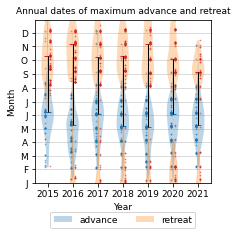

In [39]:
fig, ax = plt.subplots(figsize=(fw, 3))

# -- plot advance distribution each year
annual_advances = [max_advance_doy[x].astype('float').dropna() for x in max_advance_doy]
v1 = ax.violinplot(annual_advances, positions=YEARS, showextrema=False, showmedians=True)
v1['cmedians'].set_color('tab:blue')
for y in YEARS:
    ax.scatter((y-0.08)*np.ones(len(max_advance_doy[y])), max_advance_doy[y], marker='.', s=2, color='tab:blue', alpha=0.5)
# -- plot retreat distribution each year
annual_retreats = [max_retreat_doy[x].astype('float').dropna() for x in max_retreat_doy]
annual_retreats_nextyear = [max_retreat_doy[x].astype('float').dropna()-365 for x in max_retreat_doy]
v2 = ax.violinplot(annual_retreats, positions=YEARS, showextrema=False, showmedians=True)
v3 = ax.violinplot(annual_retreats_nextyear, positions=[x+1 for x in YEARS], showextrema=False, showmedians=False)
v2['cmedians'].set_color('tab:red')
for pc in v3['bodies']:
    pc.set_color('tab:orange')
for y in YEARS:
    # -- plot individual retreat points in their proper years
    ax.scatter((y+0.08)*np.ones(len(max_retreat_doy[y])), max_retreat_doy[y], marker='.', s=2, color='tab:red', alpha=0.5)
    # -- plot retreat points that spill over into the next year
    ax.scatter((y+1.08)*np.ones(len(max_retreat_doy[y])), max_retreat_doy[y]-365, marker='.', s=2, color='tab:red', alpha=0.5)
# -- plot duration of retreat period each year
median_advance = [x.median() for x in annual_advances]
median_retreat = [x.median() for x in annual_retreats]
ax.vlines(x=YEARS, ymin=median_advance, ymax=median_retreat, color='black')
# -- axes properties
ax.set_yticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
ax.set_yticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylim([1, 365])
ax.set_xlim([2014.5, 2021.5])
ax.set_xticks(YEARS)
ax.set_title('Annual dates of maximum advance and retreat')
ax.set_ylabel('Month')
ax.set_xlabel('Year')
ax.grid(axis='x')
ax.legend(handles=[v1['bodies'][0], v2['bodies'][0]], labels=['advance', 'retreat'], ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.15))

plt.savefig('../figures/fig3_timing_advance_retreat.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
# Get advance dates and median
print([pd.to_datetime(f'{y}{int(x)}', format='%Y%j') for x, y in zip(median_advance, YEARS)])
median_advance_date_fig3 = pd.to_datetime(f'2021{int(np.median(median_advance))}', format='%Y%j')
print(f'Median: {median_advance_date_fig3}')

[Timestamp('2015-06-08 00:00:00'), Timestamp('2016-05-09 00:00:00'), Timestamp('2017-06-03 00:00:00'), Timestamp('2018-05-07 00:00:00'), Timestamp('2019-05-06 00:00:00'), Timestamp('2020-06-03 00:00:00'), Timestamp('2021-05-09 00:00:00')]
Median: 2021-05-10 00:00:00


In [41]:
# Get retreat dates and median
print([pd.to_datetime(f'{y}{int(x)}', format='%Y%j') for x, y in zip(median_retreat, YEARS)])
median_retreat_date_fig3 = pd.to_datetime(f'2021{int(np.median(median_retreat))}', format='%Y%j')
print(f'Median: {median_retreat_date_fig3}')

[Timestamp('2015-10-10 00:00:00'), Timestamp('2016-11-04 00:00:00'), Timestamp('2017-10-09 00:00:00'), Timestamp('2018-10-10 00:00:00'), Timestamp('2019-11-06 00:00:00'), Timestamp('2020-10-03 00:00:00'), Timestamp('2021-09-04 00:00:00')]
Median: 2021-10-10 00:00:00


In [42]:
# Get duration of retreat period (time between date of max advance and max retreat) each year
retreat_duration = np.subtract(median_retreat, median_advance)
print([x for x in zip(YEARS, retreat_duration)])

[(2015, 124.0), (2016, 179.5), (2017, 128.0), (2018, 156.0), (2019, 184.0), (2020, 122.0), (2021, 118.0)]


In [43]:
print(f'The median retreat duration is {np.median(retreat_duration)} days (and the mean is {retreat_duration.mean()} days).')

The median retreat duration is 128.0 days (and the mean is 144.5 days).


In [44]:
# Get retreat duration just in NW/CW Greenland to compare with MAR data from Black and Joughin (2022)
max_advance_cnw = max_advance_doy.loc[[x for x in GIDS_CW+GIDS_NW if x in max_advance_doy.index]]
max_retreat_cnw = max_retreat_doy.loc[[x for x in GIDS_CW+GIDS_NW if x in max_retreat_doy.index]]
retreat_duration_cnw = max_retreat_cnw.median(skipna=True) - max_advance_cnw.median(skipna=True)
retreat_duration_cnw

2015    132.0
2016    162.0
2017    126.0
2018    130.0
2019    152.0
2020    120.0
2021    120.0
dtype: float64

## Numbers about magnitude of terminus seasonality

In [45]:
median_magnitude = seasonality['Median Magnitude (km)'].astype('float')
print(f'The mean terminus seasonality across Greenland is {median_magnitude.mean():.3f} km, and the median is {median_magnitude.median():.3f} km.')
print(f'Terminus seasonality ranges from {median_magnitude.min():.3f}km at {all_glaciers[median_magnitude.idxmin()].getGlacierName()} to {median_magnitude.max():.3f}km at {all_glaciers[median_magnitude.idxmax()].getGlacierName()}.')

The mean terminus seasonality across Greenland is 0.388 km, and the median is 0.221 km.
Terminus seasonality ranges from 0.042km at Glacier #232 to 2.650km at Kangerlussuaq Gletsjer.


## Figure 4: Map and histogram of distribution of seasonal magnitude

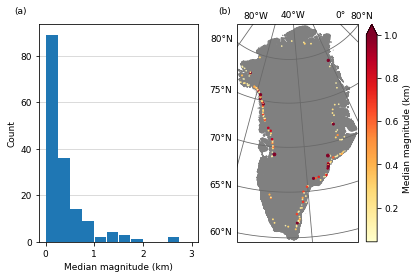

In [46]:
# TODO: also map (at least to look at) the locations of non-significant glaciers

# Create geodataframe wtih glacier point location and median annual magnitude
median_magnitude = pd.DataFrame(columns=['Glacier_ID', 'magnitude'], index=GIDS_seasonal)
median_magnitude['Glacier_ID'] = seasonality.index.values
median_magnitude['magnitude'] = seasonality['Median Magnitude (km)']
points_mag = points.merge(median_magnitude, on='Glacier_ID')
points_mag.magnitude = points_mag.magnitude.values.astype('float')

# Initalize plot of terminus seasonality magnitude
fig = plt.figure(figsize=(fw*2, 4))

# Plot histogram of median annual variabilities
ax1 = fig.add_subplot(121)
ax1.annotate(text='(a)', xy=(-0.15, 1.05), xycoords='axes fraction')
ax1.hist(points_mag.magnitude, bins=np.arange(0, points_mag.magnitude.max()+0.5, 0.25), rwidth=0.95)
ax1.set_xlabel('Median magnitude (km)')
ax1.set_ylabel('Count')
ax1.grid(axis='x')

# Plot map of median annual variabilities
ax2 = fig.add_subplot(122, projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax2.annotate(text='(b)', xy=(-0.15, 1.05), xycoords='axes fraction')
# Plot glacier points with color and size scaled to magnitude
coastline.plot(ax=ax2, color='gray', facecolor='gray', zorder=0)
points_mag.plot(ax=ax2, column='magnitude', markersize=3*points_mag.magnitude.values, cmap='YlOrRd', legend=True, vmax=1.0, legend_kwds={'extend':'max', 'label':'Median magnitude (km)'})
gl = ax2.gridlines(
    transform=ccrs.Geodetic(),
    draw_labels=True,
    x_inline=False,
    y_inline=False,
    color='dimgray',
    zorder=0.5)
gl.top_labels = True
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'rotation': 0}
gl.ylabel_style = {'rotation': 0}

xmin, ymin, xmax, ymax = coastline.total_bounds
ax2.set_xlim([xmin-20000, xmax+20000])
ax2.set_ylim([ymin-20000, ymax+20000])

# fig.suptitle('Magnitude of terminus position seasonality')

plt.savefig('../figures/fig4_magnitude_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
points_mag.sort_values('magnitude')[-10:]

,Glacier_ID,Official_Name,Greenlandic_Name,Alternative_Name,geometry,magnitude
86,120,Daugaard-Jensen Gletsjer,,,POINT (557181.942 -1896245.019),1.331127
32,35,Nunatakassaap Sermia,Nunatakassaap Sermia,Alison Glacier,POINT (-321637.685 -1645246.488),1.475398
123,175,Helheim Gletsjer,,,POINT (307626.692 -2577505.895),1.483191
113,161,,,Unartit,POINT (492502.938 -2426858.670),1.663734
111,159,,,,POINT (494199.407 -2403770.147),1.717327
41,46,Sverdrup Gletsjer,,Sverdrup Brae,POINT (-356239.034 -1527721.687),1.723597
77,107,Zachariae Isstrøm,,,POINT (493175.498 -1097644.671),1.759590
2,3,Sermeq Kujalleq,Sermeq Kujalleq,Jakobshavn Isbræ,POINT (-182396.467 -2276270.100),2.589778
105,153,Kangerlussuaq Gletsjer,,Kangerlugssuaq,POINT (488366.342 -2290977.486),2.649620
78,108,Kofoed-Hansen Bræ,,,POINT (534356.966 -1248443.951),NaN


In [48]:
points_mag[points_mag['Glacier_ID'] == 5]

,Glacier_ID,Official_Name,Greenlandic_Name,Alternative_Name,geometry,magnitude
4,5,Eqip Sermia,Eqip Sermia,,POINT (-201747.611 -2201924.089),0.286258


In [49]:
print(f'{100 * len(median_magnitude[median_magnitude["magnitude"] < 0.250]) / len(median_magnitude):.1f}% of glaciers have seasonal magnitude less than 250 m.')
print(f'{100 * len(median_magnitude[median_magnitude["magnitude"] > 0.500]) / len(median_magnitude):.1f}% of glaciers have seasonal magnitude greater than 500 m.')

55.3% of glaciers have seasonal magnitude less than 250 m.
21.7% of glaciers have seasonal magnitude greater than 500 m.


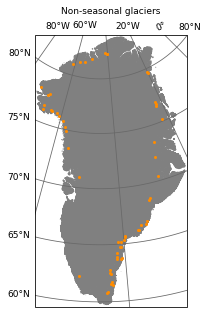

In [50]:
# Also map (at least to look at) the locations of non-significant glaciers

# Initalize plot 
fig = plt.figure(figsize=(4,5))

# Plot map of non-seasonal glaciers
ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
# Plot glacier points with color and size scaled to magnitude
coastline.plot(ax=ax, color='gray', facecolor='gray', zorder=0)
points.loc[GIDS_not_seasonal].plot(ax=ax, color='darkorange')
gl = ax.gridlines(
    transform=ccrs.Geodetic(),
    draw_labels=True,
    x_inline=False,
    y_inline=False,
    color='dimgray',
    zorder=0.5)
gl.top_labels = True
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'rotation': 0}
gl.ylabel_style = {'rotation': 0}

xmin, ymin, xmax, ymax = coastline.total_bounds
ax.set_xlim([xmin-20000, xmax+20000])
ax.set_ylim([ymin-20000, ymax+20000])
ax.set_title('Non-seasonal glaciers')

plt.show()

## Analysis: identification of retreat events in six-day records

In [51]:
# IDENTIFY ALL RETREAT EVENTS AND SAVE TO DATAFRAMES FOR ALL, MONTHLY NUM, MONTHLY MAG

retreat_threshold = 50 # in meters

# Initialize dataframes to store data about timing, number, and magnitude of retreat events
all_retreat_events = pd.DataFrame(index=pd.date_range(start='2015-01-01', end='2021-12-31', freq='1 D'), columns=GIDS6)
num_retreat_events = pd.DataFrame(index=pd.MultiIndex.from_product([list(range(1,13)), list(YEARS)], names=['month', 'year']), columns=GIDS6)
mag_retreat_events = pd.DataFrame(index=pd.MultiIndex.from_product([list(range(1,13)), list(YEARS)], names=['month', 'year']), columns=GIDS6)

for id in GIDS6:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.lengths.values, index=glacier.dates.values)
    lengths_diff = lengths.diff()
    # -- identify all retreat events (negative values)
    potential_retreat_events = lengths_diff[lengths_diff < 0]
    # -- identify all retreat events above a threshold (50m length)
    likely_retreat_events = potential_retreat_events[potential_retreat_events < -retreat_threshold/1000]
    # -- add data to retreat events dataframes
    all_retreat_events[id] = likely_retreat_events
    grouped_retreat_events = likely_retreat_events.groupby(
        [likely_retreat_events.index.month, likely_retreat_events.index.year])
    num_retreat_events[id] = grouped_retreat_events.count()
    mag_retreat_events[id] = grouped_retreat_events.sum()*-1

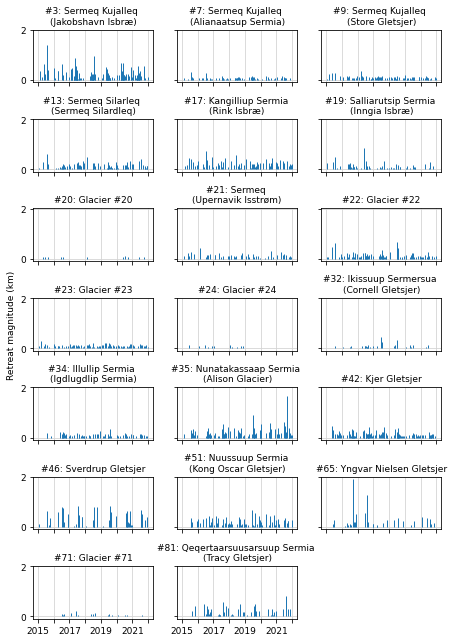

In [52]:
# PLOT RETREAT EVENTS FOR INDIVIDUAL GLACIERS

fig, ax = plt.subplots(nrows=7, ncols=3, sharex=True, sharey=True, figsize=(fw*2, 9))
ax = ax.flatten()

for id in GIDS6:
    glacier = all_glaciers[id]
    glacier_retreats = all_retreat_events[id].dropna()
    # -- plot timing and magnitude of all retreat events for each glacier
    n = GIDS6.index(id)
    ax[n].vlines(x=glacier_retreats.index, ymin=0, ymax=-1*glacier_retreats.values)
    name = glacier.getGlacierName()
    if '(' in name:
        name_parts = name.split('(')
        name_2line = name_parts[0] + '\n(' + name_parts[1]
        ax[n].set_title(f'#{id}: {name_2line}')
    else:
        ax[n].set_title(f'#{id}: {name}')
    ax[n].grid('on')
ax[-1].axis('off')
ax[9].set_ylabel('Retreat magnitude (km)')
plt.tight_layout()
ax[-3].set_xticks(pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))
ax[-3].set_xticklabels(labels=['2015', '', '2017', '', '2019', '', '2021', ''])
plt.savefig('../figures/figS4_retreat_events_individual.png', dpi=300, bbox_inches='tight')
plt.show()

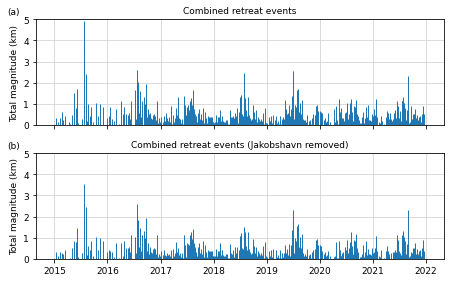

In [71]:
# PLOT CUMULATIVE RETREAT EVENTS OVER ALL GLACIERS, WITH/WITHOUT JAKOBSHAVN

cumulative_daily_retreat = all_retreat_events.sum(axis=1)
cumulative_daily_retreat_nojak = all_retreat_events.drop(3, axis=1).sum(axis=1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(fw*2, 4))
ax1.annotate(text='(a)', xy=(-0.07, 1.05), xycoords='axes fraction')
ax2.annotate(text='(b)', xy=(-0.07, 1.05), xycoords='axes fraction')
# -- Plot cumulative daily retreat for all six-day glaciers
ax1.vlines(x=cumulative_daily_retreat.index, ymin=0, ymax=-1*cumulative_daily_retreat.values)
ax1.set_title('Combined retreat events')
ax1.set_ylabel('Total magnitude (km)')
ax1.set_ylim([0, 5])
# -- Plot cumulative daily retreat for all six-day glaciers except Jakobshavn
ax2.vlines(x=cumulative_daily_retreat_nojak.index, ymin=0, ymax=-1*cumulative_daily_retreat_nojak.values)
ax2.set_title('Combined retreat events (Jakobshavn removed)')
ax2.set_ylabel('Total magnitude (km)')
ax2.set_ylim([0, 5])
plt.tight_layout()
plt.savefig('../figures/figS5_retreat_events_combined.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 5: timing and magnitude of retreat events

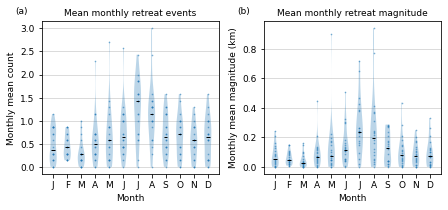

In [54]:
# PLOT MONTHLY NUMBER AND MAGNITUDE OF RETREAT EVENTS

# Get average number and magnitude of retreat events each month
num_retreat_events.replace(np.nan, 0, inplace=True)
mag_retreat_events.replace(np.nan, 0, inplace=True)
monthly_num_retreat_events = num_retreat_events.groupby('month').mean().transpose()
monthly_mag_retreat_events = mag_retreat_events.groupby('month').mean().transpose()

# Violin plots of mean monthly number and magnitude of retreat events for each glacier
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(fw*2, 3))
ax1.annotate(text='(a)', xy=(-0.15, 1.05), xycoords='axes fraction')
ax2.annotate(text='(b)', xy=(-0.15, 1.05), xycoords='axes fraction')
# -- mean monthly number of retreat events
v1 = ax1.violinplot(monthly_num_retreat_events, positions=range(1,13), showextrema=False, showmedians=True)
v1['cmedians'].set_color('black')
for m in range(1,13):
    ax1.scatter(m*np.ones(len(monthly_num_retreat_events[m])), monthly_num_retreat_events[m], marker='.', s=2, color='tab:blue', alpha=0.5)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax1.set_ylabel('Monthly mean count')
ax1.set_xlabel('Month')
ax1.set_title('Mean monthly retreat events')
ax1.grid(axis='x')
# -- mean monthly magnitude of retreat events
v2 = ax2.violinplot(monthly_mag_retreat_events, positions=range(1,13), showextrema=False, showmedians=True)
v2['cmedians'].set_color('black')
for m in range(1,13):
    ax2.scatter(m*np.ones(len(monthly_mag_retreat_events[m])), monthly_mag_retreat_events[m], marker='.', s=2, color='tab:blue', alpha=0.5)
ax2.set_ylabel('Monthly mean magnitude (km)')
ax2.set_xlabel('Month')
ax2.set_title('Mean monthly retreat magnitude')
ax2.grid(axis='x')
plt.tight_layout()
plt.savefig('../figures/fig5_retreat_timing_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# Which months have the most and least number of retreat events?
monthly_num_retreat_events.median().sort_values()

month
3     0.285714
1     0.357143
2     0.428571
4     0.500000
5     0.571429
11    0.571429
6     0.642857
9     0.642857
12    0.642857
10    0.714286
8     1.142857
7     1.428571
dtype: float64

In [56]:
# Which months have the greatest and least magnitude of retreat events?
monthly_mag_retreat_events.median().sort_values()

month
3     0.024370
2     0.046493
1     0.050092
4     0.067498
11    0.070464
12    0.074480
5     0.075243
10    0.077442
6     0.115445
9     0.128139
8     0.196631
7     0.238379
dtype: float64

## Relationship between seasonal magnitude and glacier width?

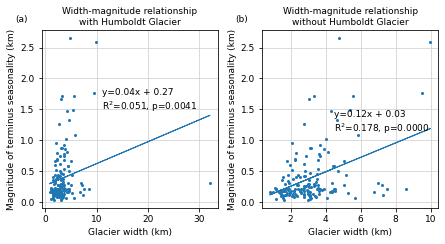

In [69]:
# PLOT MAGNITUDE VS WIDTH FOR ALL SEASONAL GLACIERS 

# Create dataframe of glacier widths and magnitudes, with and without Humboldt glacier
glacier_widths = pd.DataFrame(index=GIDS_seasonal, columns=['width', 'magnitude'], dtype='float')
glacier_widths['width'] = glacier_widths.apply(lambda row: all_glaciers[row.name].widths.mean(), axis=1)
glacier_widths['magnitude'] = seasonality['Median Magnitude (km)'].astype('float')
glacier_widths = glacier_widths.dropna()
glacier_widths_nohumboldt = glacier_widths[glacier_widths.index != 92]

# Plot glacier magnitude vs width
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(fw*2, fw*1.1))
ax1.annotate(text='(a)', xy=(-0.15, 1.05), xycoords='axes fraction')
ax2.annotate(text='(b)', xy=(-0.15, 1.05), xycoords='axes fraction')
# -- With Humboldt
ax1.scatter(glacier_widths['width'], glacier_widths['magnitude'])
slope, intercept, r_value, p_value, std_err = linregress(glacier_widths['width'], glacier_widths['magnitude'])
ax1.plot(glacier_widths['width'], slope*glacier_widths['width']+intercept)
ax1.annotate(text=f'y={slope:.2f}x + {intercept:.2f}\nR$^2$={r_value**2:.3f}, p={p_value:.4f}', xy=(11, 1.5), xycoords='data')
ax1.set_xlabel('Glacier width (km)')
ax1.set_ylabel('Magnitude of terminus seasonality (km)')
ax1.set_title('Width-magnitude relationship\nwith Humboldt Glacier')
# -- Without Humboldt
ax2.scatter(glacier_widths_nohumboldt['width'], glacier_widths_nohumboldt['magnitude'])
slope, intercept, r_value, p_value, std_err = linregress(glacier_widths_nohumboldt['width'], glacier_widths_nohumboldt['magnitude'])
ax2.plot(glacier_widths_nohumboldt['width'], slope*glacier_widths_nohumboldt['width']+intercept)
ax2.annotate(text=f'y={slope:.2f}x + {intercept:.2f}\nR$^2$={r_value**2:.3f}, p={p_value:.4f}', xy=(4.5, 1.15), xycoords='data')
ax2.set_xlabel('Glacier width (km)')
ax2.set_ylabel('Magnitude of terminus seasonality (km)')
ax2.set_title('Width-magnitude relationship\nwithout Humboldt Glacier')

plt.tight_layout()
plt.savefig('../figures/figS6_width_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
glacier_widths.sort_values('width')

,width,magnitude
239,0.819226,0.162469
237,1.010422,0.161753
170,1.127712,0.232233
151,1.169060,0.220860
231,1.184065,0.217140
...,...,...
105,7.485982,0.222905
147,8.567113,0.219059
107,9.510770,1.759590
3,9.978329,2.589778


In [59]:
# LOOK AT RELATIONSHIP BETWEEN SMALL MAGNITUDE (<1KM) AND WIDTH
# Seale et al. (2011) found that glaciers with variations <1km were typically <2km wide

mag_below_1 = glacier_widths[glacier_widths['magnitude'] < 1]
wid_below_2 = mag_below_1[mag_below_1['width'] > 2]
print(f'Of {len(mag_below_1)} glaciers with seasonal magnitudes less than 1km, {len(wid_below_2)} glaciers ({100*len(wid_below_2)/len(mag_below_1):.1f}%) have widths greater than 2km.\nThis could be biased in that we only looked at glaciers at least 1-1.5 km wide.')

Of 148 glaciers with seasonal magnitudes less than 1km, 107 glaciers (72.3%) have widths greater than 2km.
This could be biased in that we only looked at glaciers at least 1-1.5 km wide.


In [60]:
# LOOK AT WIDTHS FOR NON-SEASONAL GLACIERS
glacier_widths_ns = pd.DataFrame(index=GIDS_not_seasonal, columns=['width'], dtype='float')
glacier_widths_ns['width'] = glacier_widths_ns.apply(lambda row: all_glaciers[row.name].widths.mean(), axis=1)
glacier_widths_ns.sort_values('width')

,width
101,0.992192
238,1.183272
89,1.240211
197,1.263786
217,1.380975
152,1.400843
123,1.419005
222,1.420783
83,1.434144
235,1.442411


## Relationship between seasonal magnitude and glacier velocity?

In [61]:
# Initialize dataframe to store glacier mean velocities
glacier_velocities = pd.DataFrame(index=GIDS, columns=['velocity'])

# Load glacier velocity data following https://github.com/fastice/GrIMPNotebooks/blob/master/workingWithGrIMPVelocity.ipynb
myVel = nisar.nisarVel()
myVel.readDataFromTiff(velocity_file, url=False, readSpeed=False)

# Loop over all glaciers
for id in GIDS:
    glacier = all_glaciers[id]

    # Find x, y coordinates of most retreated terminus
    most_retreated_xy = list(glacier.obsseries[glacier.areas.idxmin()].terminus.geoms[0].coords)
    x = [c[0] for c in most_retreated_xy]
    y = [c[1] for c in most_retreated_xy]

    # Interpolate velocity to terminus coordinates
    vxInterp, vyInterp, vvInterp = myVel.interp(x, y, units='m')

    # Get mean velocity along terminus and add to dataframe
    mean_velocity = np.nanmean(vvInterp)
    glacier_velocities.loc[id] = mean_velocity

# Add magnitudes to dataframe
glacier_velocities['magnitude'] = seasonality['Median Magnitude (km)'].astype('float')

glacier_velocities

<ipython-input-61-fd7091070fda>:21: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(vvInterp)
<ipython-input-61-fd7091070fda>:21: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(vvInterp)
<ipython-input-61-fd7091070fda>:21: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(vvInterp)
<ipython-input-61-fd7091070fda>:21: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(vvInterp)
<ipython-input-61-fd7091070fda>:21: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(vvInterp)
<ipython-input-61-fd7091070fda>:21: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(vvInterp)
<ipython-input-61-fd7091070fda>:21: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(vvInterp)
<ipython-input-61-fd7091070fda>:21: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(vvInterp)
<ipython-input-61-fd7091070fda>:21: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(vvInterp)
<

,velocity,magnitude
1,402.686091,0.167087
2,67.204666,0.111839
3,3892.304478,2.589778
4,282.382897,0.077883
5,1123.069837,0.286258
...,...,...
235,50.604055,NaN
236,1712.208023,0.291955
237,NaN,0.161753
238,274.152727,NaN


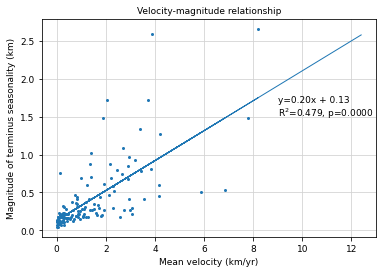

In [62]:
# Plot glacier magnitude vs velocity
glacier_velocities['velocity_km'] = glacier_velocities['velocity']/1000
fig, ax = plt.subplots()
ax.scatter(glacier_velocities['velocity_km'], glacier_velocities['magnitude'])
slope, intercept, r_value, p_value, std_err = linregress(glacier_velocities.dropna()['velocity_km'].astype('float'), glacier_velocities.dropna()['magnitude'])
ax.plot(glacier_velocities['velocity_km'], slope*glacier_velocities['velocity_km']+intercept)
ax.annotate(text=f'y={slope:.2f}x + {intercept:.2f}\nR$^2$={r_value**2:.3f}, p={p_value:.4f}', xy=(9, 1.5), xycoords='data')
ax.set_xlabel('Mean velocity (km/yr)')
ax.set_ylabel('Magnitude of terminus seasonality (km)')
ax.set_title('Velocity-magnitude relationship')

plt.savefig('../figures/figS7_velocity_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
# Get velocity of non-seasonal and seasonal glaciers
vel_not_seasonal = glacier_velocities.loc[GIDS_not_seasonal]
print(f'{100*len(vel_not_seasonal[vel_not_seasonal["velocity"] < 1000])/len(GIDS_not_seasonal):.0f}% of non-seasonal glaciers have velocities below 1 km/yr.')
print(f'The mean velocity of non-seasonal glaciers is {vel_not_seasonal["velocity_km"].mean():.1f} km/yr (median is {vel_not_seasonal["velocity_km"].median():.3f} km/yr)')

vel_seasonal = glacier_velocities.loc[GIDS_seasonal]
print(f'\n{100*len(vel_seasonal[vel_seasonal["velocity"] < 1000])/len(GIDS_seasonal):.0f}% of seasonal glaciers have velocities below 1 km/yr.')
print(f'The mean velocity of seasonal glaciers is {vel_seasonal["velocity_km"].mean():.1f} km/yr (median is {vel_seasonal["velocity_km"].median():.3f} km/yr)')

64% of non-seasonal glaciers have velocities below 1 km/yr.
The mean velocity of non-seasonal glaciers is 1.2 km/yr (median is 0.197 km/yr)

47% of seasonal glaciers have velocities below 1 km/yr.
The mean velocity of seasonal glaciers is 1.3 km/yr (median is 0.837 km/yr)
